In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, TensorBoard
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
import seaborn as sns
from datetime import datetime
from sklearn.metrics import mean_squared_error
from tensorflow.keras.backend import clear_session
import gc

In [2]:
data = pd.read_csv('all_data_results_cleaned.csv')

In [3]:
data["allowable_velocity"] = data["allowable_deformation"]*2*np.pi*data["frequency"]

In [4]:
drop_vel_top=np.percentile(data["allowable_velocity"], 99)
drop_vel_bot=np.percentile(data["allowable_velocity"], 1)

data.drop(data[(data.allowable_velocity > drop_vel_top)].index , inplace=True)
data.drop(data[(data.allowable_velocity < drop_vel_bot)].index , inplace=True)

In [5]:
to_drop=[
        "outside_diameter", "wall_thickness", "raised_face_depth",
        "w_neck_c", "flange_outer_radius", "flange_thickness_d","raised_face_radius",
        "y_deformation_position", "z_deformation_position",
        "hot_spot_stress", "max_deformation", "support_right", "support_left", "ratio",
        "allowable_deformation"
        ]
to_keep=[
        "pipe_dn","pipe_schedule","flange_class",
        "length1", "length2", "lumped_mass",
        "frequency","x_deformation_position","allowable_velocity","support"
        ]

data.drop(columns=to_drop,inplace=True)

In [6]:
numeric_features = [
    "pipe_dn",
    'length1', 'length2', 'lumped_mass',
    ]
categorical_features = ['support',"pipe_schedule","flange_class"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop=None), categorical_features)
    ])

In [7]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

In [8]:
output_columns = ['allowable_velocity', 'frequency', 'x_deformation_position']
x = data.drop(output_columns, axis=1)
y = pd.DataFrame(data[output_columns])

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=30)

In [10]:
x_train_transformed = pipeline.fit_transform(x_train)
x_test_transformed = pipeline.transform(x_test)

In [11]:
scaler_y_frequency = StandardScaler()
scaler_y_allowed_velocity = StandardScaler()
scaler_y_x_position = StandardScaler()

y_train_transformed_frequency = scaler_y_frequency.fit_transform(pd.DataFrame(y_train["frequency"]))
y_test_transformed_frequency = scaler_y_frequency.transform(pd.DataFrame(y_test["frequency"]))

y_train_transformed_allowable_velocity = scaler_y_allowed_velocity.fit_transform(pd.DataFrame(y_train["allowable_velocity"]))
y_test_transformed_allowable_velocity = scaler_y_allowed_velocity.transform(pd.DataFrame(y_test["allowable_velocity"]))

y_train_transformed_x_displacement = scaler_y_x_position.fit_transform(pd.DataFrame(y_train["x_deformation_position"]))
y_test_transformed_x_displacement = scaler_y_x_position.transform(pd.DataFrame(y_test["x_deformation_position"]))



In [12]:
logdir = "logs/deformation_class/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=logdir)

In [13]:
input_layer = Input(shape=(x_train_transformed.shape[1],))
hidden1 = Dense(512, activation='relu')(input_layer)
dropout1 = Dropout(0.2)(hidden1)
hidden2 = Dense(128, activation='relu')(dropout1)


# Separate output for each target variable
output_layer = Dense(1)(hidden2)
#, name='allowable_deformation'


In [14]:
model = Model(inputs=input_layer, outputs=output_layer)

In [15]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='mse',
              metrics=["R2Score"])

In [17]:
history = model.fit(
    x_train_transformed, 
    y_train_transformed_allowable_velocity,  # Split the targets into separate arrays
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    verbose=1,
    callbacks=[tensorboard_callback]
)

Epoch 1/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - R2Score: 0.5145 - loss: 0.5506 - val_R2Score: 0.8336 - val_loss: 0.1718
Epoch 2/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - R2Score: 0.8371 - loss: 0.1556 - val_R2Score: 0.8564 - val_loss: 0.1482
Epoch 3/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - R2Score: 0.8448 - loss: 0.1580 - val_R2Score: 0.8595 - val_loss: 0.1450
Epoch 4/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.8464 - loss: 0.1475 - val_R2Score: 0.8720 - val_loss: 0.1321
Epoch 5/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.8585 - loss: 0.1409 - val_R2Score: 0.8795 - val_loss: 0.1244
Epoch 6/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - R2Score: 0.8652 - loss: 0.1293 - val_R2Score: 0.8826 - val_loss: 0.1212
Epoch 7/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - R2Score: 0.8852 - loss: 0.1201 - val_R2Score: 0.8727 - val_loss: 0.1314
Epoch 8/100
121/121 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - R2Score: 0.8743 - loss: 0.1281 - val_R2Score: 0.8856 - 

In [18]:
test_loss, test_mse = model.evaluate(x_test_transformed, y_test_transformed_allowable_velocity)
print('Test accuracy:', test_mse)

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - R2Score: 0.9181 - loss: 0.0800
Test accuracy: 0.9114269018173218


In [19]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │         8,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 223,493 (873.02 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 148,996 (582.02 KB)

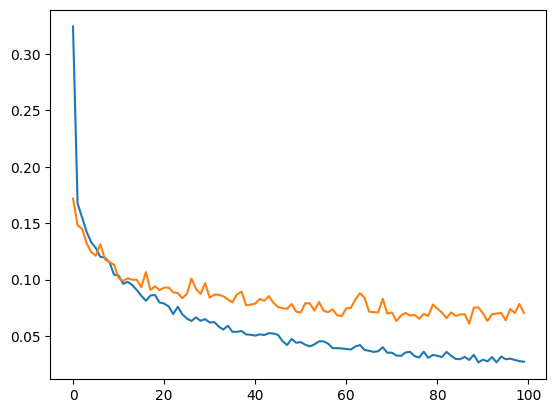

In [20]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")

In [21]:
predictions_scaled = model.predict(x_test_transformed)
predictions = scaler_y_allowed_velocity.inverse_transform((predictions_scaled))

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [22]:
predictions_df = pd.DataFrame(predictions)
print(predictions_df)

                0
0     1002.551147
1      347.440857
2      379.494934
3      258.765076
4      395.793854
...           ...
2403   633.418091
2404   393.654541
2405   604.650574
2406   348.999817
2407  1666.629150

[2408 rows x 1 columns]


In [23]:
y_test["allowable_velocity"]

2273      937.818883
2753      343.812924
6348      324.492157
8023      300.751256
2004      361.314629
            ...     
6450      522.825428
2783      332.999331
1290      479.895193
10716     254.805277
4130     1929.937891
Name: allowable_velocity, Length: 2408, dtype: float64

In [24]:
true= y_test["allowable_velocity"].tolist()
pred= predictions_df[0].tolist()
mean_squared_error(true,pred)

111481.89319035923

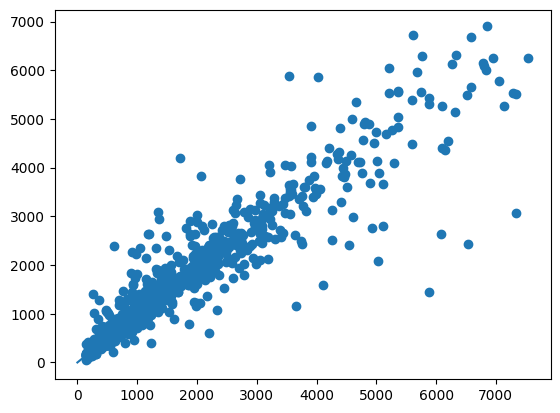

In [25]:
pred=predictions_df
ansys=y_test["allowable_velocity"]
plt.scatter(ansys,pred)
#plt.loglog()
plt.plot([0, 700],[0, 700])
plt.show()

In [26]:
clear_session()
del model
gc.collect()

0